# Simultaneous Fitting of a Transit with Stellar Variability

In [1]:
import exoplanet as xo

xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.3.dev9+gbd01ddd'


Previous case studies have looked at [fitting transits](https://gallery.exoplanet.codes/tutorials/transit/), as well as [using Gaussian process models](https://gallery.exoplanet.codes/tutorials/stellar-variability/) to fit stellar variability.  This case study looks at how we can combine these two features of _exoplanet_ to simultaneously fit the stellar variability and transit in the Kepler 1627 Ab (KIC 6184894).  This system is in a [40 million year old open cluster](https://github.com/lgbouma/rudolf/blob/main/paper/ms.pdf), so it's a good example of the kind of analysis required for young transiting planets.

# Datasets and initializations

First, let's download the long cadence light curves from MAST using the `lightkurve` package.

In [2]:
import lightkurve as lk
import numpy as np, matplotlib.pyplot as plt

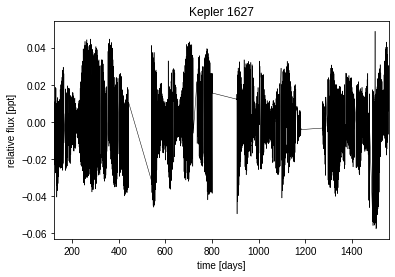

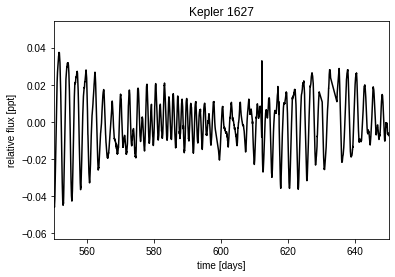

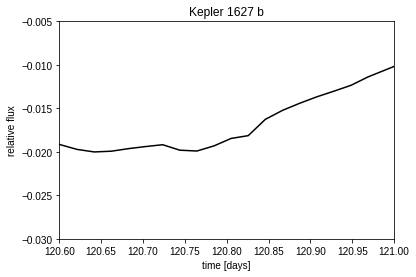

In [3]:
# Get long cadence light curves for all quarters. Median normalize all
# quarters, remove nans, and run a 5-sigma outlier clipping.
lcf = lk.search_lightcurve(
    "6184894", mission="Kepler", author="Kepler", cadence="long"
).download_all()
lc = lcf.stitch().remove_nans().remove_outliers()

# Require non-zero quality flags, since we have an abundance of data.
lc = lc[lc.quality == 0]

# Make sure that the data type is consistent
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))

# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu

# Visualize the data.
# Plot #0: full dataset
# Plot #1: a 100 day slice
# Plot #2: center it on the known Kepler ephemeris.
plt.plot(x, y, "k", lw=0.5)
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("Kepler 1627")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.xlim([550, 650])
plt.title("Kepler 1627")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([120.6, 121])  # transit is here
plt.ylim([-30e-3, -5e-3])
plt.title("Kepler 1627 b")
plt.show()

# A simultaneous transit and Gaussian process model

That planet is really hidden!  Fortunately, Kepler observed ~140 transits, so we can do a lot better than the single transit that we can (maybe) see in the second plot there.  To do that, let's build a model that accounts for the spot-induced signal through a GP, and the transit signal separately.

In [4]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

from astropy import units as units, constants as const


def build_model(mask=None, start=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=1, testval=0)

        # Stellar parameters.  These are usually determined from spectroscopy
        # and/or isochrone fits.
        logg_star = pm.Normal("logg_star", mu=4.53, sd=0.05)
        r_star = pm.Normal("r_star", mu=0.881, sd=0.018)

        # Here "factor" is defined s.t. factor * 10**logg / r_star = rho
        factor = 5.141596357654149e-05
        rho_star = pm.Deterministic(
            "rho_star", factor * 10**logg_star / r_star
        )

        # Limb-darkening: adopt Kipping 2013.
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # To get Rp/R*, fit for log(depth).  This requires an impact parameter
        # prior from 0 to 1, because otherwise there's a sqrt(1-b^2) in the
        # conversion that doesn't make sense.  See
        # https://github.com/exoplanet-dev/exoplanet/blob/e99d1bd68654f21efbbf8400a83889a470d2baf7/src/exoplanet/light_curves/limb_dark.py#L73

        b = pm.Uniform("b", lower=0, upper=1)

        log_depth = pm.Normal("log_depth", mu=np.log(1.8e-3), sigma=1)
        depth = pm.Deterministic("depth", tt.exp(log_depth))

        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(depth, b),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        # Orbital parameters for the planet.  Use mean values from Holczer+16.
        t0 = pm.Normal("t0", mu=120.790, sd=0.02, testval=120.790)
        period = pm.Normal("period", mu=7.203, sd=0.01, testval=7.203)

        # Let the eccentricity float, and use the eccentricity distribution
        # from https://arxiv.org/abs/1807.00549 as our prior.
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=False, shape=1, fixed=True, observed=ecc
        )
        # Alternative choice:
        # xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Define the orbit model.
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            b=b,
            rho_star=rho_star,
            r_star=r_star,
            ecc=ecc,
            omega=omega,
        )

        transit_model = mean + tt.sum(
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
            axis=-1,
        )

        # Convenience function for plotting.
        pm.Deterministic(
            "transit_pred",
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
        )

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is 2.6 days, from Lomb Scargle
        log_prot = pm.Normal("log_prot", mu=np.log(2.606418), sd=0.02)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        #
        # Note mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        #
        gp = GaussianProcess(
            kernel,
            t=x[mask],
            diag=yerr[mask] ** 2 + tt.exp(2 * log_jitter),
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y[mask] - transit_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y[mask] - transit_model))

        # Track planet radius in Jovian radii
        r_planet = pm.Deterministic(
            "r_planet",
            (ror * r_star) * (1 * units.Rsun / (1 * units.Rjup)).cgs.value,
        )

        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                log_depth,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                logg_star,
                u_star,
                mean,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model, map_estimate = build_model()

optimizing logp for variables: [log_dQ, log_Q0, log_prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: 111227.12300632945 -> 267403.1186250675


optimizing logp for variables: [mean, u_star, logg_star, r_star, period, t0, ecs, b, log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: 267403.11862506747 -> 268086.2151628799


optimizing logp for variables: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, ecs, period, t0, log_depth, b, u_star, r_star, logg_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 268086.2151628799 -> 271185.49517391546


Good! The log probability has increased at each step, which is typically what we want to see during optimization.
In the following cells, we'll define a plotting function that we can then use to visualize the model and the best-fit estimate.

In [5]:
import matplotlib as mpl


def plot_light_curve(x, y, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=0.5,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=41, lw=0.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(
            x[mask],
            mod,
            label="planet {0} [model under]".format(l),
            zorder=-10,
        )
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(x[mask], mod, label="planet {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + np.sum(soln["transit_pred"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

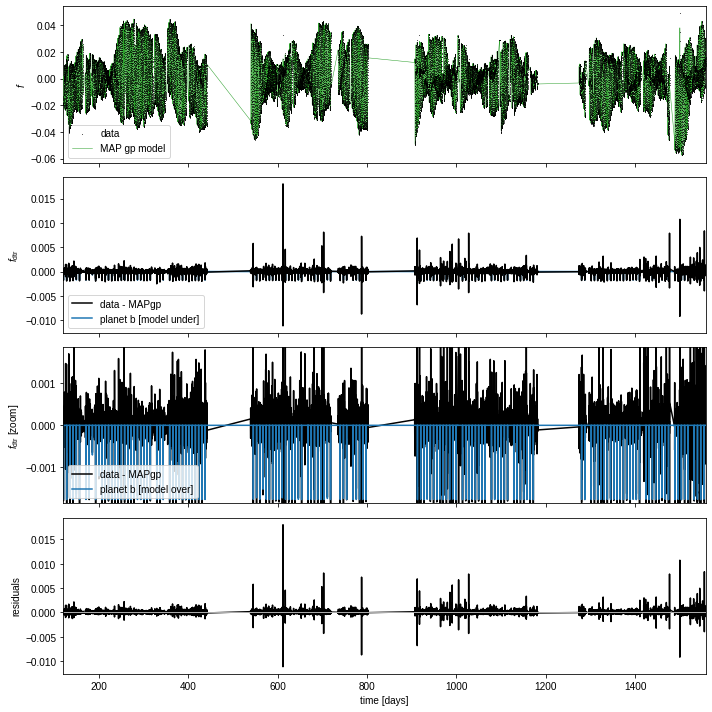

In [6]:
plot_light_curve(x, y, map_estimate)

This looks more or less like what we're hoping for.  The full Kepler time-series is dominated by the spot-induced variability, but the GP does a good job at removing it.  In some cases, we might want to exclude the outlier points here as well, but for now there's no obvious need to do this.

Let's take a look at the phase-folded data:

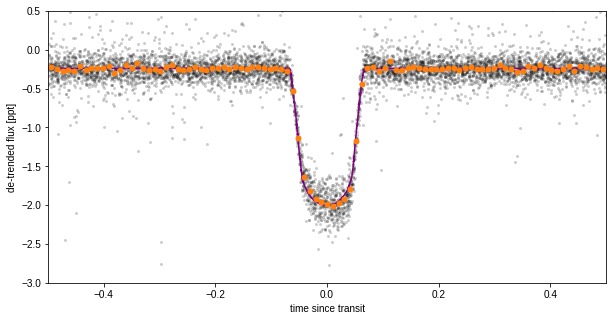

In [7]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))

# Ephemeris from Holczer+16
t0 = 120.790531
period = 7.20280608

x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - map_estimate["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.2,
    linewidths=0,
)

lc_mod = map_estimate["transit_pred"][:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + map_estimate["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - map_estimate["gp_pred"])
denom[num == 0] = 1.0
ax.scatter(
    0.5 * (bins[1:] + bins[:-1]),
    1e3 * num / denom,
    color="C1",
    zorder=2,
    linewidths=0,
)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-3, 0.5)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

Nice! The phase-folded light curve shows the transit at much higher signal to noise. The data even seems like they might be asymmetric, but it'd require a lot more work to see whether or not that's robust.

Taking a look at some of the MAP parameters:

In [8]:
params = (
    "mean,logg_star,r_star,period,t0,log_depth,b,log_jitter,log_prot"
    ",log_Q0,log_dQ,r_star,rho_star,depth,ror,sigma_rot,prot,f,r_planet".split(
        ","
    )
)
for p in params:
    print(f"{p}: {map_estimate[p]:.5f}")

mean: -0.00024
logg_star: 4.52565
r_star: 0.88128
period: 7.20280
t0: 120.79044
log_depth: -6.33771
b: 0.53717
log_jitter: -8.03477
log_prot: 0.97783
log_Q0: -0.32690
log_dQ: 7.70411
r_star: 0.88128
rho_star: 1.95720
depth: 0.00177
ror: 0.03979
sigma_rot: 0.06962
prot: 2.65867
f: 0.01009
r_planet: 0.34124


Things look about right.  The planet is about $3.9 R_\oplus$, on a close-in orbit.  It's worth noting that the MAP value of $f$, the mixing fraction between the two frequencies in the `RotationTerm` kernel, favors a value so low to the bottom of our prior.   Also, we should check whether our jitter makes sense:

In [9]:
print(f"jitter is {np.exp(map_estimate['log_jitter'])*1e3:.2f} ppt")
print(f"mean(yerr) is {np.mean(yerr)*1e3:.2f} ppt")

jitter is 0.32 ppt
mean(yerr) is 0.11 ppt


So the jitter will inflate the uncertainties by around a factor of three.  If this is a concern, sigma-clipping to remove outliers as in the {ref}`tess` case study might be worthwhile.

# Sampling

Finally, we can of course go on to sample.  This takes a few hours to convergence on a typical MacBook, and so to keep this notebook from requiring lots of resources, by default we won't do it.

In [10]:
import platform
import arviz as az

# Change this to "1" if you wish to run it.
RUN_THE_SAMPLING = 0

if RUN_THE_SAMPLING:

    with model:
        trace = pm.sample(
            tune=1500,
            draws=1000,
            start=map_estimate,
            # Parallel sampling runs poorly or crashes on macos
            cores=1 if platform.system() == "Darwin" else 2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
            random_seed=[261136679, 261136680],
            init="adapt_full",
        )

    az.summary(
        trace,
        var_names=[
            "mean",
            "logg_star",
            "r_star",
            "t0",
            "period",
            "b",
            "u_star",
            "log_depth",
            "depth",
            "ecc",
            "omega",
            "log_jitter",
            "sigma_rot",
            "log_prot",
            "log_Q0",
            "log_dQ",
            "f",
            "r_planet",
        ],
    )